# Verification of generated Sequences

In this notebook we explore and verify our solution for the HLA-A gene.

## Section 1: Setup

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
from gentype import AlleleMM, get_distances
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import sys

Set up Classes:

In [2]:
Database_Name = "Gentype_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Setting the paramaters for our selected allele: HLA-A. For options for ref_name and population_name you can also take a look at the database after fetching.

In [3]:
region_start = 29941260
region_end = 29945884
ref_name = "6" # generally the name of the chromosome
population_name = "ALL"
project_name = "1000GENOMES:phase_3"
allele_args = {'start' : region_start, 'end' : region_end, 'reference_name' : ref_name, 'population' : population_name, 'project' : project_name}

We use store magic to store the values of costly computations (data fetching, model training), so they only have to be done once.

Initialize storable data:

In [4]:
fetched = False
inference_matrix = None
eval_models = None

Restore stored data (remove # to recompute instead of restore respective data):

In [5]:
#%store -d fetched # if you want to refetch the data, uncomment this line
#%store -d inference_matrix # if you want to recompute the inference_matrix, uncomment this line
#%store -d eval_models # if you want to recompute the models, uncomment this line
%store -r

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This only needs to be done once but might take a while.

In [6]:
if not fetched:
    data_manager.fetch_all(region_start, region_end, ref_name, report_progress = True)
fetched = True
%store fetched

Finished fetching reference set.
Finished fetching reference sequences for set: GRCh38.
Finished fetching populations for species: homo_sapiens.
Finished fetching individuals for population: African Caribbean in Barbados.
Finished fetching individuals for population: African.
Finished fetching individuals for population: All phase 3 individuals.
Finished fetching individuals for population: American.
Finished fetching individuals for population: African Ancestry in Southwest US.
Finished fetching individuals for population: Bengali in Bangladesh.
Finished fetching individuals for population: Chinese Dai in Xishuangbanna, China.
Finished fetching individuals for population: Utah residents with Northern and Western European ancestry.
Finished fetching individuals for population: Han Chinese in Bejing, China.
Finished fetching individuals for population: Southern Han Chinese, China.
Finished fetching individuals for population: Colombian in Medellin, Colombia.
Finished fetching individual

The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. 

Each row in the matrix represents the variants present in each individual as a bitvector.

In [7]:
if inference_matrix is None:
    inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(**allele_args)
%store inference_matrix 
%store individual_map 
%store variation_map
inference_matrix.shape

Stored 'inference_matrix' (ndarray)
Stored 'individual_map' (dict)
Stored 'variation_map' (dict)


(5008, 438)

## Section 3: Splitting test and training Data

In order to verify our data, we split our known data into a test and training set.
We will verify our algorithm by comparing the generated data with know existing data which was not used to train the model. Thus we unconventionally choose an even split.

In [ ]:
split_point = int(len(inference_matrix)/2)
# if we want to keep using our mapping we need to use the first half for training
inference_matrix_training = inference_matrix[:split_point]
inference_matrix_test = inference_matrix[split_point:]


In the PCA plot we can see that our training and test sets are fairly evenly distributed.

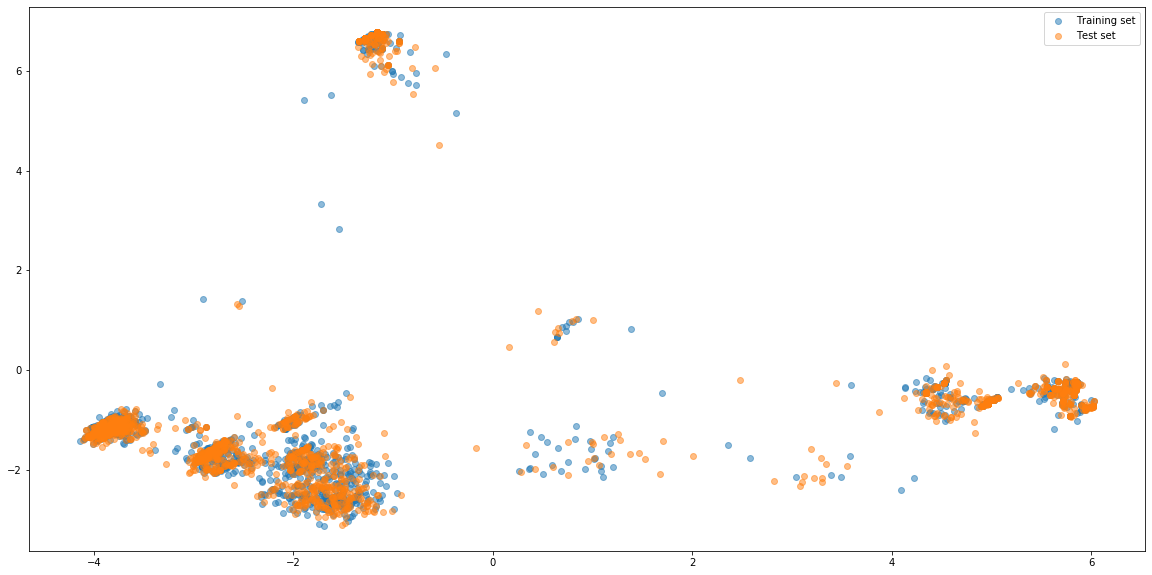

In [9]:
fig, ax = plt.subplots(figsize = (20,10))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
pca.explained_variance_ratio_.cumsum()
ax.plot(principalComponents[:split_point,0], principalComponents[:split_point,1], "o", alpha=0.5)
ax.plot(principalComponents[split_point:,0], principalComponents[split_point:,1], "o", alpha=0.5)
ax.legend(["Training set", "Test set"])

## Section 4: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

Model 0:
Iteration: 1; Current clusters: 8; Likelihood: -1120707.897
Iteration: 2; Current clusters: 8; Likelihood: -1109911.102
Iteration: 3; Current clusters: 8; Likelihood: -1108176.527
Iteration: 4; Current clusters: 7; Likelihood: -1107818.239
Iteration: 5; Current clusters: 7; Likelihood: -1107788.819
Iteration: 6; Current clusters: 7; Likelihood: -1107758.195
Iteration: 7; Current clusters: 7; Likelihood: -1107764.588
Iteration: 8; Current clusters: 7; Likelihood: -1107724.333
Iteration: 9; Current clusters: 7; Likelihood: -1107774.596
Iteration: 10; Current clusters: 7; Likelihood: -1107704.712
Iteration: 11; Current clusters: 7; Likelihood: -1107845.520
Iteration: 12; Current clusters: 7; Likelihood: -1107855.776
Iteration: 13; Current clusters: 7; Likelihood: -1107788.874
Iteration: 14; Current clusters: 7; Likelihood: -1107833.444
Iteration: 15; Current clusters: 7; Likelihood: -1107703.588
Iteration: 16; Current clusters: 7; Likelihood: -1107784.262
Iteration: 17; Current c

Iteration: 135; Current clusters: 7; Likelihood: -1107831.552
Iteration: 136; Current clusters: 7; Likelihood: -1107792.339
Iteration: 137; Current clusters: 7; Likelihood: -1107850.668
Iteration: 138; Current clusters: 7; Likelihood: -1107812.174
Iteration: 139; Current clusters: 7; Likelihood: -1107800.395
Iteration: 140; Current clusters: 7; Likelihood: -1107752.748
Iteration: 141; Current clusters: 7; Likelihood: -1107661.978
Iteration: 142; Current clusters: 7; Likelihood: -1107808.794
Iteration: 143; Current clusters: 7; Likelihood: -1107800.115
Iteration: 144; Current clusters: 7; Likelihood: -1107829.031
Iteration: 145; Current clusters: 7; Likelihood: -1107801.475
Model 1:
Iteration: 1; Current clusters: 9; Likelihood: -1113939.033
Iteration: 2; Current clusters: 9; Likelihood: -1107822.916
Iteration: 3; Current clusters: 9; Likelihood: -1104494.042
Iteration: 4; Current clusters: 9; Likelihood: -1103811.351
Iteration: 5; Current clusters: 8; Likelihood: -1100174.332
Iteration

Iteration: 124; Current clusters: 8; Likelihood: -1098562.884
Iteration: 125; Current clusters: 8; Likelihood: -1098553.661
Iteration: 126; Current clusters: 8; Likelihood: -1098597.321
Iteration: 127; Current clusters: 8; Likelihood: -1098601.821
Iteration: 128; Current clusters: 8; Likelihood: -1098568.200
Iteration: 129; Current clusters: 8; Likelihood: -1098533.910
Iteration: 130; Current clusters: 8; Likelihood: -1098499.758
Iteration: 131; Current clusters: 8; Likelihood: -1098529.330
Iteration: 132; Current clusters: 9; Likelihood: -1098567.388
Iteration: 133; Current clusters: 8; Likelihood: -1098396.501
Iteration: 134; Current clusters: 8; Likelihood: -1098427.995
Iteration: 135; Current clusters: 8; Likelihood: -1098471.335
Iteration: 136; Current clusters: 8; Likelihood: -1098484.420
Iteration: 137; Current clusters: 8; Likelihood: -1098546.359
Iteration: 138; Current clusters: 8; Likelihood: -1098514.253
Iteration: 139; Current clusters: 8; Likelihood: -1098544.525
Iteratio

Iteration: 87; Current clusters: 10; Likelihood: -1105246.387
Iteration: 88; Current clusters: 10; Likelihood: -1105231.686
Iteration: 89; Current clusters: 9; Likelihood: -1105208.210
Iteration: 90; Current clusters: 11; Likelihood: -1105274.782
Iteration: 91; Current clusters: 9; Likelihood: -1105180.941
Iteration: 92; Current clusters: 9; Likelihood: -1105218.320
Iteration: 93; Current clusters: 11; Likelihood: -1105255.027
Iteration: 94; Current clusters: 9; Likelihood: -1105172.019
Iteration: 95; Current clusters: 11; Likelihood: -1105160.024
Iteration: 96; Current clusters: 9; Likelihood: -1105106.234
Iteration: 97; Current clusters: 9; Likelihood: -1105237.456
Iteration: 98; Current clusters: 10; Likelihood: -1105280.690
Iteration: 99; Current clusters: 10; Likelihood: -1105287.114
Iteration: 100; Current clusters: 9; Likelihood: -1105260.952
Iteration: 101; Current clusters: 10; Likelihood: -1105229.276
Iteration: 102; Current clusters: 13; Likelihood: -1105283.425
Iteration: 1

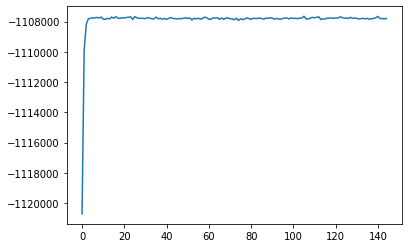

Model 1 with 7.0 clusters:


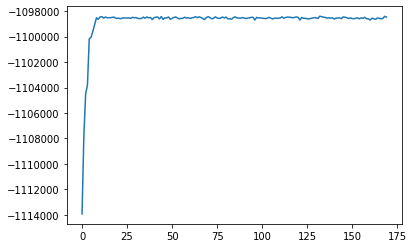

Model 2 with 9.0 clusters:


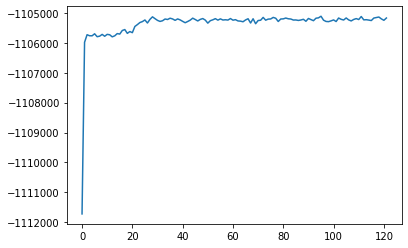

Stored 'eval_models' (list)


In [10]:
number_models = 3
if eval_models is None:
    eval_models = [PiCollapsedNonparametricGibbsSampler(42) for i in range(number_models)]
    for i in range(0, len(eval_models)):
        print("Model {}:".format(i))
        eval_models[i].fit(inference_matrix_training, num_burn_in_steps = 100, delta = 1, alpha = 10**(i - 1))
for i in range(0, len(eval_models)):
    print("Model {} with {} clusters:".format(i, max(eval_models[i].Z)))
    plt.clf()
    plt.plot(eval_models[i].ll_list)
    plt.show()

%store eval_models

May pre select models e.g. according to Aitikens Information Criterion (AIC).

In [11]:
def AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood
values = list(map(lambda x: AIC(x), eval_models))
print(values)
best_idx = values.index(min(values))
print("Chose model {}.".format(best_idx))

[2221734.949619845, 2203929.6730219023, 2219090.50733476]
Chose model 1.


## Section 5: Verifying the Generation

Generate a good amount of samples (the more the better, but also the longer it will take) and store additional information. Then compute the distance metrics.

In [12]:
variant_ranges = data_manager.get_variation_range(**allele_args)
mm = AlleleMM(eval_models[best_idx].Z, eval_models[best_idx].theta, inference_matrix_training, variant_ranges, variation_map)
number_of_samples = 100
samples = []
clusters = []
descriptions = []
for i in range(number_of_samples):
    characteristic_vector = np.zeros(len(eval_models[best_idx].theta[0]))
    sample, cluster = mm.sample_variations(return_cluster = True)
    characteristic_vector[sample] = 1
    samples.append(characteristic_vector)
    clusters.append(cluster)
assigned_distance, distribution_difference, assignments = get_distances(samples, inference_matrix_test, return_assignments = True)
print("Average assigned distances: {}\nDistribution difference: {}".format(sum(assigned_distance.values())/len(samples), distribution_difference))

We can plot the distances for each sequence by the cluster they were generated by to gain further insight.

Average assigned distances: 20.79
Distribution difference: 1.4934504792332783


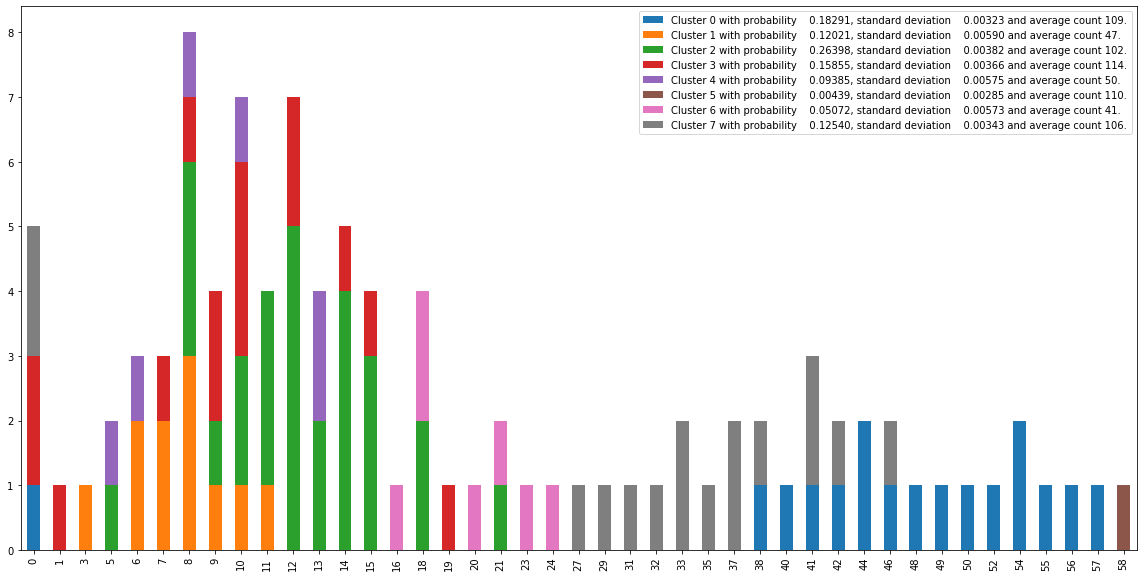

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
assigned_distance_clusters = []
distances = set()
for i in range(mm.clusters):
    assigned_distance_clusters.append([])
for i, sample in enumerate(samples):
    assigned_distance_clusters[clusters[i]].append(assigned_distance[tuple(sample)])
    distances.add(assigned_distance[tuple(sample)])

distances = list(distances)
distances.sort()

cluster_per_distances = []
for distance in distances:
    cluster_per_distance = []
    for cluster in assigned_distance_clusters:
        cluster_per_distance.append(cluster.count(distance))
    cluster_per_distances.append(cluster_per_distance)
cluster_per_distances = np.array(cluster_per_distances)

standard_deviations = [np.std(mm.theta[i]) for i in range(mm.clusters)]
avg_count = []
for i in range(mm.clusters):
    choices, probabilites = mm.distributions[i]
    avg_count.append(int(sum(choice * prob for choice, prob in zip(choices, probabilites))))
descriptions = ["Cluster {} with probability {:10.5f}, standard deviation {:10.5f} and average count {}.".format(i, mm.pi[i], standard_deviations[i], avg_count[i]) for i in range(mm.clusters)]
df = pd.DataFrame(dict(zip(descriptions, cluster_per_distances.T)))
df.index = distances

df.plot(kind="bar", stacked=True, ax=ax)

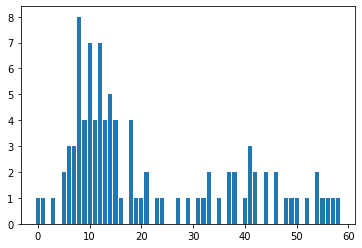

In [14]:
from collections import Counter
c = Counter(assigned_distance.values())
plt.bar(c.keys(), c.values())
plt.show()

In [25]:
cluster_diff_count = 0
seen = []
for i, row in enumerate(inference_matrix_training):
    if str(row) in seen: continue
    seen.append(str(row))
    for j, sample in enumerate(samples):
        if (assignments[tuple(sample)] == tuple(row)).all() and mm.Z[i] != clusters[j]:
            cluster_diff_count += 1
cluster_diff_count
        
    

6

In [26]:
def KL_div(p, q):
    return np.nan_to_num([p[i] * np.log(p[i]/q[i]) for i in range(len(p))]).sum()

In [27]:
null_model = inference_matrix_training.sum(axis=0)
null_model /= inference_matrix_training.sum()
null_model.shape
draws = inference_matrix_training.sum(axis=1)
unique_elements, counts_elements = np.unique(draws, return_counts=True)
counts_elements = counts_elements / counts_elements.sum()
KL_div(null_model, models[0].theta[0])

/home/finn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/finn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


1.2083898423930934

In [28]:
null_samples = []
for i in range(100):
    s = np.zeros(438)
    variants =  np.random.choice(range(438), p= null_model, size = int(np.random.choice(unique_elements, p =counts_elements)), replace=False)
    for var in variants:
        s[var] = 1
    null_samples.append(s)

Average assigned distances: 63.36
 Distribution difference: 1.5949201277955778


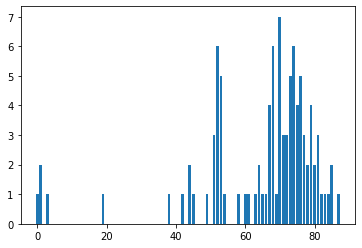

In [29]:
assigned_distance, distribution_difference = get_distances(null_samples, inference_matrix_test)
print("Average assigned distances: {}\n Distribution difference: {}".format(sum(assigned_distance.values())/len(samples), distribution_difference))
from collections import Counter
c = Counter(assigned_distance.values())
plt.bar(c.keys(), c.values())
plt.show()

In [30]:
training_assigned_distance, training_distribution_difference = get_distances(inference_matrix_training, inference_matrix_test)
%store training_avg_assigned_distance
%store training_distribution_difference
sum(training_assigned_distance.values())/len(samples), training_distribution_difference

Stored 'training_avg_assigned_distance' (float)
Stored 'training_distribution_difference' (float64)


(dict_values([4, 0, 7, 4, 0, 1, 1, 3, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 6, 0, 7, 0, 42, 7, 1, 3, 0, 9, 5, 0, 0, 3, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 0, 8, 14, 0, 0, 10, 0, 1, 3, 14, 9, 3, 1, 1, 0, 0, 0, 12, 5, 0, 1, 17, 2, 0, 6, 2, 1, 1, 0, 0, 3, 1, 0, 0, 1, 5, 2, 2, 0, 16, 1, 10, 1, 2, 0, 4, 2, 6, 2, 1, 0, 13, 1, 4, 3, 2, 1, 5, 4, 8, 2, 17, 0, 0, 2, 3, 0, 4, 7, 0, 3, 10, 2, 1, 5, 1, 3, 1, 1, 0, 1, 21, 5, 0, 0, 12, 3, 1, 3, 0, 4, 2, 1, 1, 1, 2, 1, 0, 13, 0, 0, 1, 1, 1, 4, 2, 7, 1, 5, 2, 1, 8, 10, 4, 4, 6, 0, 0, 12, 5, 2, 1, 6, 1, 2, 7, 2, 14, 0, 3, 1, 1, 1, 16, 9, 1, 0, 3, 3, 2, 1, 1, 0, 0, 5, 5, 5, 9, 2, 0, 9, 1, 1, 0, 4, 0, 0, 0, 1, 0, 2, 0, 0, 3, 3, 0, 0, 1, 1, 5, 8, 3, 11, 1, 1, 0, 0, 13, 19, 17, 20, 1, 1, 0, 4, 3, 13, 0, 2, 0, 1, 2, 2, 1, 2, 3, 1, 7, 0, 1, 1, 1, 2, 9, 0, 4, 8, 1, 0, 0, 1, 9, 3, 3, 0, 0, 15, 8, 0, 3, 12, 32, 27, 0, 2, 4, 6, 4, 0, 35, 47, 1, 0, 2, 8, 1, 1, 0, 2, 2, 1, 1, 4, 1, 4, 5, 2, 0, 0, 8, 8, 1, 2, 3, 10, 10, 6, 0, 1, 11, 1,